In [52]:
%pylab inline
import pandas as pd
import seaborn as sns
import os, glob

Populating the interactive namespace from numpy and matplotlib


/home/grigory/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
#Load data
df = pd.read_csv('log_410k.csv',sep=',',quotechar='/', index_col='id')
df['article_url'] = df['article_url'].apply(lambda _: _[len('/wiki/'):])
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410799 entries, 0 to 410798
Data columns (total 5 columns):
categories     409583 non-null object
article_url    410799 non-null object
name           408277 non-null object
author         410799 non-null object
author_url     410799 non-null object
dtypes: object(5)
memory usage: 18.8+ MB


## Анализ

Получаем все возможные категории( с повторением)

In [4]:
df['cats'] = df['categories'].str.split('##')
total_categories = []
df['cats'].apply(lambda _: total_categories.extend(_ if _ is not nan else []));
categories = pd.Series(total_categories)

Наиболее популярные категории  и авторы

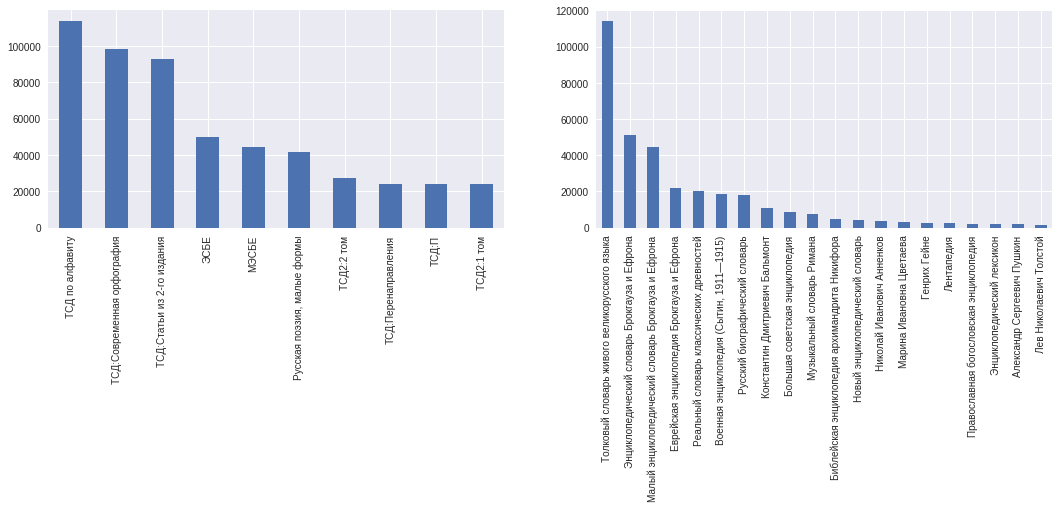

In [5]:
plt.subplots(1,2,figsize=(18,4))
plt.subplot(1,2,1)
categories.value_counts()[:10].plot.bar();

plt.subplot(1,2,2)
df['author'].value_counts()[:20].plot.bar();

## Фильтруем произведения

In [328]:
acounts = df['author'].value_counts().reset_index()
acounts.columns = ['author','count']
words = ['словар','энциклоп']
mask = acounts['author'].apply(lambda _:  sum(name in _.lower() for name in words)==0)
print('Число "нормальных" авторов:', acounts[mask].shape[0])
print('Суммарное число их произведений:', acounts[mask]['count'].values.sum())

Число "нормальных" авторов: 1895
Суммарное число их произведений: 91974


Запомним всех "ненормальных" авторов

In [50]:
import pickle
with open('bad_guys.pckl','wb') as f:
    pickle.dump(set(acounts[~mask]['author'].values.tolist()),file=f, protocol=2)
with open('bad_guys.pckl','rb') as fr:
    data = pickle.load(fr)
data
shortcuts = {'САР','ПБЭ','РБС',
'ЭВМН','БЭЮ','ЕЭБЕ',
'СЭС','ББСРП','ВЭ',
'НЭС','РСКД','ТСЖВЯ',
'БЭАН','ТЭ','МЭСБЕ',
'ЭСБЕ','МСР','ГССРИ',
'ЭЛ','БСЭ','РЭСБ', 'ВЭЛ'}
with open('bad_guys_shortcuts.pckl','wb') as f:
    pickle.dump(shortcuts,file=f, protocol=2)

{'Библейская энциклопедия архимандрита Никифора',
 'Био-библиографический словарь русских писателей XX века',
 'Большая советская энциклопедия',
 'Большая энциклопедия Южакова',
 'Военная энциклопедия (Сытин, 1911—1915)',
 'Военный энциклопедический лексикон',
 'Географическо-статистический словарь Российской империи',
 'Еврейская энциклопедия Брокгауза и Ефрона',
 'Малый энциклопедический словарь Брокгауза и Ефрона',
 'Музыкальный словарь Римана',
 'Новый энциклопедический словарь',
 'Православная богословская энциклопедия',
 'Реальный словарь классических древностей',
 'Русский биографический словарь',
 'Русский энциклопедический словарь И. Н. Березина',
 'Словарь Академии Российской',
 'Справочный энциклопедический словарь',
 'Техническая энциклопедия',
 'Толковый словарь живого великорусского языка',
 'Энциклопедический лексикон',
 'Энциклопедический словарь Брокгауза и Ефрона',
 'Энциклопедия военных и морских наук'}

Выделим из "нормальных" авторов, тех авторов, чьё число статей больше 20

In [148]:
count_threshold = 20
normal_authors = set(acounts[mask][acounts[mask]['count']>count_threshold]['author'].values)

In [154]:
normal_authors_mask = df['author'].apply(lambda _: _ in normal_authors)
normal_authors_mask.sum()

86119

Итого из $\approx$ 410 тысяч статей имеем 86119 нормальных произведений всех тех авторов, чьё число произведений больше 20.

Обобщим, и посмотрим как сильно проседает число выборки с ростом порога по числу статей

In [179]:
%%time
count_thresholds = list(range(10,1001, 50))
sizes = []
authors_counts = []
categories_counts = []
for threshold in count_thresholds:
    normal_authors = set(acounts[mask][acounts[mask]['count']>threshold]['author'].values)
    authors_counts.append(len(normal_authors))
    normal_authors_mask = df['author'].apply(lambda _: _ in normal_authors)
    sizes.append(normal_authors_mask.sum())

    total_categories = []
    df[normal_authors_mask]['cats'].apply(lambda _: total_categories.extend(_ if _ is not nan else []));
    categories_counts.append(pd.Series(total_categories).unique().shape[0])

CPU times: user 3.54 s, sys: 0 ns, total: 3.54 s
Wall time: 3.54 s


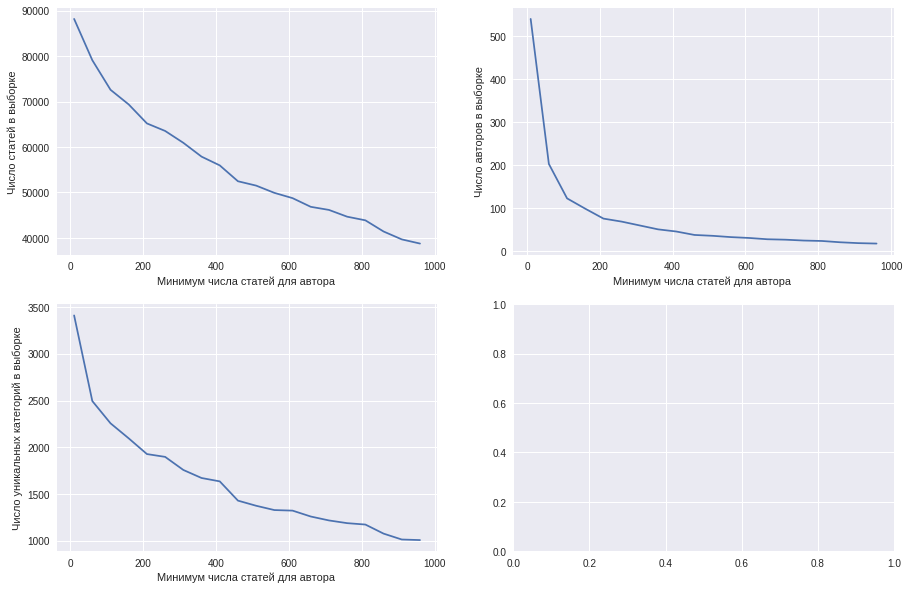

In [181]:
plt.subplots(2,2,figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(count_thresholds, sizes);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число статей в выборке')
plt.subplot(2,2,2)
plt.plot(count_thresholds, authors_counts);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число авторов в выборке');

plt.subplot(2,2,3)
plt.plot(count_thresholds, categories_counts);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число уникальных категорий в выборке');

## Анализ  статей из отдельных категорий

In [283]:
def analyze_category_mask(category_name, count_threshold, qrange):
    mask = df['cats'].apply(lambda _: (category_name in _) if _ not in [None,nan] else False)
    print('Общее число статей в категории:', mask.sum())
    counts = df[mask]['author'].value_counts()
    
    print('Число уникальных авторов в разделе поэзия: {}'.format(counts.shape[0]))
    print('Число уникальных авторов в разделе поэзия с более чем {} статьями: {}'.format(count_threshold, 
                               counts[counts.values>count_threshold].shape[0]))
    
    print('Общее число их статей в разделе поэзия: {}'.format(
                        counts[counts.values>count_threshold].values.sum()))

    q1,q2 = qrange
    q1v = np.percentile(counts[counts.values>count_threshold].values, q1)
    q2v = np.percentile(counts[counts.values>count_threshold].values, q2)
    print(('Можно утверждать, что число статей для {:.3f}  авторов из выборки  '
            'лежит в интервале: ({},{})').format((q2-q1)/100, q1v,q2v))
    
    return counts, mask

In [294]:
import json 
from lxml import html

def get_content(id_, datapath='/media/grigory/Data/WIKIDATA'):
    with open(os.path.join(datapath, str(id_)+'.json'),'r') as f:
        file_content = json.load(f)
    html_dom = html.fromstring(file_content['body'])
    try:
#         poetry_dom = html_dom.xpath(r'//div[@class="poem"]')
#         drama_dom = html_dom.xpath(r'//div[@class="drama text"]')
#         text = html_dom.xpath(r'//div[@class="indent"]')
        raw_text = html_dom.xpath(r'//div[@class="mw-parser-output"]//p')
        return '\n\n'.join(p.text_content() for p \
                          in raw_text if p.getparent().get('class') is not None)
    except IndexError:
        pass

## *"Русская поэзия, малые формы"*

In [295]:
poetry_counts, mask = analyze_category_mask('Русская поэзия, малые формы', 100, (30,90))

Общее число статей в категории: 41459
Число уникальных авторов в разделе поэзия: 421
Число уникальных авторов в разделе поэзия с более чем 100 статьями: 56
Общее число их статей в разделе поэзия: 37395
Можно утверждать, что число статей для 0.600  авторов из выборки  лежит в интервале: (224.0,1105.5)


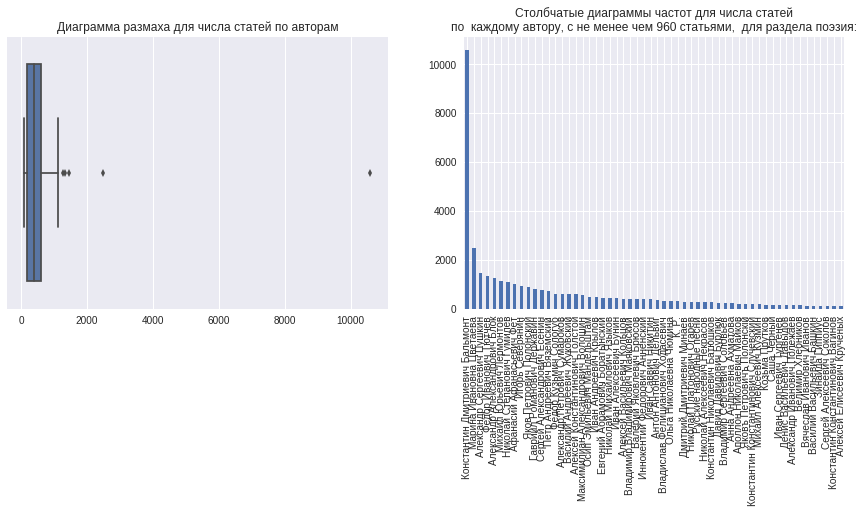

In [296]:
plt.subplots(1,2,figsize=(15,5));
plt.subplot(1,2,1)
sns.boxplot(poetry_counts[poetry_counts.values>100].values);
plt.title('Диаграмма размаха для числа статей по авторам');

plt.subplot(1,2,2)
poetry_counts[poetry_counts.values>100].plot.bar();
plt.title('Столбчатые диаграммы частот для числа статей\nпо  каждому автору, с не менее чем'
          ' {} статьями,  для раздела поэзия:'.format(threshold));

In [322]:
%%time
lengths = []
for i, article_id in enumerate(mask[mask].index):
    content = get_content(article_id).strip()
    lengths.append(len(content))
lengths = pd.Series(lengths)

CPU times: user 2min 45s, sys: 6.61 s, total: 2min 52s
Wall time: 10min 42s


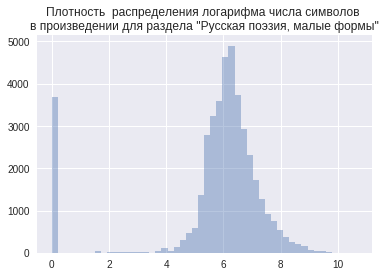

In [323]:
sns.distplot(np.log(lengths+1), kde=False);
plt.title('Плотность  распределения логарифма числа символов \nв произведении для раздела "Русская поэзия, малые формы"');

## *"Русская проза, малые формы"*

In [324]:
_, mask = analyze_category_mask('Русская проза, малые формы', 20, (40,95));

Общее число статей в категории: 5194
Число уникальных авторов в разделе поэзия: 113
Число уникальных авторов в разделе поэзия с более чем 20 статьями: 43
Общее число их статей в разделе поэзия: 4767
Можно утверждать, что число статей для 0.550  авторов из выборки  лежит в интервале: (37.8,533.7999999999996)


In [325]:
%%time
lengths = []
for i, article_id in enumerate(mask[mask].index):
    content = get_content(article_id).strip()
    lengths.append(len(content))
lengths = pd.Series(lengths)

CPU times: user 44.6 s, sys: 1.15 s, total: 45.7 s
Wall time: 2min 33s


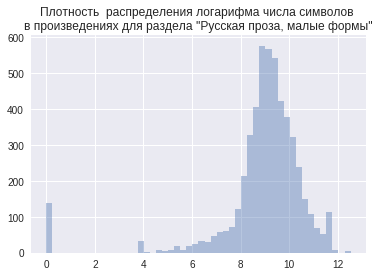

In [327]:
sns.distplot(np.log(lengths+1), kde=False);
plt.title('Плотность  распределения логарифма числа символов \nв произведениях для раздела'
          '"Русская проза, малые формы"');

# Выводы:

- нужно фильтровать статьи из словарей и энциклопедий на этапе сбора, ибо толку от них ноль, но при этом их очень много. Как это провернуть - другой вопрос, ибо можно видеть, что если фильтровать по названию, то нужно,как минимум, учитывать склонения  и регистр этих слов.(P.S. ещё есть какая-то Лентапедия, но её проще фильтрануть ручками потом, т.к. она одна такая). **Update:** фильтровать по url оказалось не так просто из-за сокращений. Так что фильтруем уже после чтения страницы.

- добавить поле "непроверенная статья"(verified) в лог, чтобы по логу можно было  отсекать битые статейки